## Quantum prisoners:Implementing quantum game theory with trapped ions
### Changhao Li, Wenchao Xu, Guoqing Wang
#### Masachusetts Institute of Technology, 2022 Jan
### changhao@mit.edu

Reference: 
Phys. Rev. Lett. 88, 137902 (2002)

J. Phys. A: Math. Gen. 36 (2003) 6551–6562

New J. Phys. 12 063031 （2010）

Quantum Information Processing (2018) 17:309

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

In [2]:
import numpy as np
from math import pi
import math
import matplotlib.pyplot as plt
from qiskit import BasicAer
from qiskit.quantum_info.operators import Operator

In [3]:
provider = AzureQuantumProvider(
  resource_id="/subscriptions/b1d7f7f8-743f-458e-b3a0-3e09734d716d/resourceGroups/aq-hackathons/providers/Microsoft.Quantum/Workspaces/aq-hackathon-01",
  location="East US"
)

In [4]:
print([backend.name() for backend in provider.backends()])

['ionq.qpu', 'ionq.simulator']


In [5]:
qasm_backend = BasicAer.get_backend('qasm_simulator')
simulator_backend = provider.get_backend("ionq.simulator")

## Creation of circuit

In [67]:
# Create a Quantum Circuit acting on the q register
q = QuantumRegister(2)
c = ClassicalRegister(2)

gamma = pi/4  #gamma=0 (1) corresponds to seperable (maximal entangled) states.
circuit = QuantumCircuit(q,c)
circuit.name = "2players"

Jmatrix = Operator([[np.cos(gamma/2),0,0,-1j*np.sin(gamma/2)],[0,np.cos(gamma/2),1j*np.sin(gamma/2),0],[0,1j*np.sin(gamma/2),np.cos(gamma/2),0],[-1j*np.sin(gamma/2),0,0,np.cos(gamma/2)]])
Jinverse = Jmatrix.adjoint()

circuit.append(Jmatrix,[q[0],q[1]])
circuit.append(Q,[q[0]])
circuit.append(D,[q[1]])
circuit.append(Jinverse,[q[0],q[1]])  
circuit = transpile(circuit,qasm_backend,basis_gates=['id','sx','cx','rz','x','y','z'],optimization_level=3)
circuit.measure(q,c)

circuit.draw()

┌────────┐     ┌────┐    ┌──────────┐                   ┌────┐   »
q751_0: ┤ Rz(-π) ├─────┤ √X ├────┤ Rz(-π/2) ├─────────────■─────┤ √X ├───»
        └─┬────┬─┘┌────┴────┴───┐└──┬────┬──┘┌─────────┐┌─┴─┐┌──┴────┴──┐»
q751_1: ──┤ √X ├──┤ Rz(-3.1403) ├───┤ √X ├───┤ Rz(π/2) ├┤ X ├┤ Rz(-π/2) ├»
          └────┘  └─────────────┘   └────┘   └─────────┘└───┘└──────────┘»
 c47: 2/═════════════════════════════════════════════════════════════════»
                                                                         »
«        ┌────────┐                     
«q751_0: ┤ Rz(-π) ├─────────────────────
«        └─┬────┬─┘┌─────────────┐┌────┐
«q751_1: ──┤ √X ├──┤ Rz(-1.5695) ├┤ √X ├
«          └────┘  └─────────────┘└────┘
« c47: 2/═══════════════════════════════
«

In [59]:
## uncomment the text below to get the effective unitary evolution matrix
## note that circuit.measure(q,c) should not be included to compute the following unitary

#backend = BasicAer.get_backend('unitary_simulator')
#job = backend.run(transpile(circuit, backend))
#job.result().get_unitary(circuit, decimals=3)

array([[ 0.+0.j,  0.+0.j,  0.+1.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -0.-1.j],
       [-0.-1.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+1.j,  0.+0.j,  0.+0.j]])

we next simuate the above circuit using the simulator backend.

In [13]:
job = simulator_backend.run(circuit, shots=100)
job_id = job.id()
print("Job id", job_id)
job_monitor(job)

Job id fadb4b38-8159-11ec-9240-38f9d3315497
Job Status: job has successfully run


Result(backend_name='ionq.simulator', backend_version='1', qobj_id='2players', job_id='fadb4b38-8159-11ec-9240-38f9d3315497', success=True, results=[ExperimentResult(shots=100, success=True, meas_level=2, data=ExperimentResultData(counts=defaultdict(<class 'int'>, {'10': 100}), probabilities=defaultdict(<class 'int'>, {'10': 1})), header=QobjExperimentHeader(meas_map='[0, 1]', name='2players', num_qubits='2', qiskit='True'))])
{'00': 0, '01': 0, '10': 100, '11': 0}


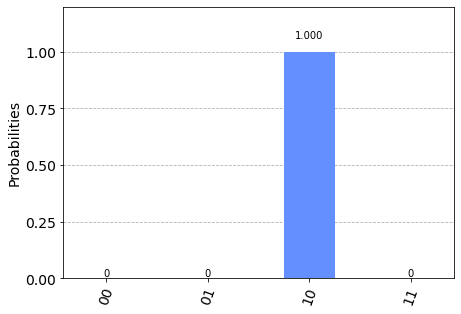

In [14]:
result = job.result()
type(result)
print(result)
counts = {format(n, "02b"): 0 for n in range(4)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts)

## Run simulations

In [ ]:
## define the unitary evolution matrix for a single qubit
def unitary(theta,phi):
    return Operator([[np.exp(1j*phi)*np.cos(theta/2),np.sin(theta/2)],[-np.sin(theta/2),np.exp(-1j*phi)*np.cos(theta/2)]])
Q = unitary(0,np.pi/2)
D = unitary(np.pi,0)


In [ ]:
## define the function for simulation

def prob_simu(gamma,shots,strategy,if_draw_circuit):
    ## gamma: the target entangled state that one creates with Jmatrix
    ## shots: number of shots in simulator backend
    ## strategy: local operations performed by Alice (q[0]) and Bob (q[1])
    ## if_draw_circuit: option to draw the cirucuit
    ## Return a list of number of shots in the computational basis of the qubits.
    
    q = QuantumRegister(2)
    c = ClassicalRegister(2)

    circuit = QuantumCircuit(q,c)
    circuit.name = "2players"
    
    Jmatrix = Operator([[np.cos(gamma/2),0,0,-1j*np.sin(gamma/2)],[0,np.cos(gamma/2),1j*np.sin(gamma/2),0],[0,1j*np.sin(gamma/2),np.cos(gamma/2),0],[-1j*np.sin(gamma/2),0,0,np.cos(gamma/2)]])
    Jtemp = Jmatrix.transpose()
    Jinverse = Jtemp.conjugate()

    circuit.append(Jmatrix,[q[0],q[1]])

    if strategy == 'QD':
        circuit.append(Q,[q[0]]);circuit.append(D,[q[1]]) # operation Q+D in Du's RPL
    if strategy == 'DD':
        circuit.append(D,[q[0]]);circuit.append(D,[q[1]]) # operation D+D in Du's RPL
    if strategy == 'QQ':
        circuit.append(Q,[q[0]]);circuit.append(Q,[q[1]]) # operation Q+Q in Du's RPL
    
    circuit.append(Jinverse,[q[0],q[1]])
    

    circuit = transpile(circuit,qasm_backend,basis_gates=['id','sx','cx','rz','x'],optimization_level=3)
    circuit.measure(q,c)
    if if_draw_circuit==1: 
        circuit.draw()
        
    job = simulator_backend.run(circuit, shots=100)
    job_id = job.id()
    #print("Job id", job_id)
    job_monitor(job)
    
    result = job.result()
    counts = {format(n, "02b"): 0 for n in range(4)}
    counts.update(result.get_counts(circuit))
    plot_histogram(counts)  
    
    return list(counts.values())

In [71]:
if_draw_circuit = 1
shots = 100
strategy = 'QD'

gamma_list = np.linspace(0,pi/2,21)
result_list = []
for gamma in gamma_list:
    tmp= prob_simu(gamma,shots,strategy, if_draw_circuit)
    print(tmp)
    result_list.append(tmp)

Job Status: job has successfully run
[0, 0, 100, 0]
Job Status: job has successfully run
[0, 0, 99, 0]
Job Status: job has successfully run
[0, 2, 97, 0]
Job Status: job has successfully run
[0, 5, 94, 0]
Job Status: job has successfully run
[0, 9, 90, 0]
Job Status: job has successfully run
[0, 14, 85, 0]
Job Status: job has successfully run
[0, 20, 79, 0]
Job Status: job has successfully run
[0, 27, 72, 0]
Job Status: job has successfully run
[0, 34, 65, 0]
Job Status: job has successfully run
[0, 42, 57, 0]
Job Status: job has successfully run
[0, 50, 50, 0]
Job Status: job has successfully run
[0, 57, 42, 0]
Job Status: job has successfully run
[0, 65, 34, 0]
Job Status: job has successfully run
[0, 72, 27, 0]
Job Status: job has successfully run
[0, 79, 20, 0]
Job Status: job has successfully run
[0, 85, 14, 0]
Job Status: job has successfully run
[0, 90, 9, 0]
Job Status: job has successfully run
[0, 94, 5, 0]
Job Status: job has successfully run
[0, 97, 2, 0]
Job Status: job has

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


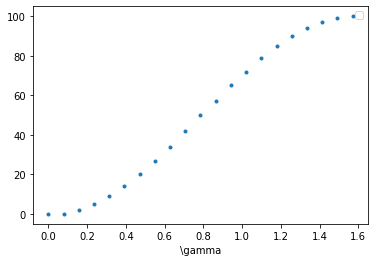

In [84]:
res = np.array(result_list).T.tolist()
plt.figure()
plt.plot(gamma_list,res[1],'.')
plt.xlabel('\gamma')
plt.legend()

# IonQ implementation

In [9]:
def prob_ionQ(gamma,shots,strategy):
    
    ## gamma: the target entangled state that one creates with Jmatrix
    ## shots: number of shots in simulator backend (dummy variable here)
    ## strategy: local operations performed by Alice (q[0]) and Bob (q[1])
    ## Return a list of number of shots in the computational basis of the qubits.
    
    q = QuantumRegister(2)
    c = ClassicalRegister(2)

    circuit = QuantumCircuit(q,c)
    circuit.name = "2players"
    
    Jmatrix = Operator([[np.cos(gamma/2),0,0,-1j*np.sin(gamma/2)],[0,np.cos(gamma/2),1j*np.sin(gamma/2),0],[0,1j*np.sin(gamma/2),np.cos(gamma/2),0],[-1j*np.sin(gamma/2),0,0,np.cos(gamma/2)]])
    Jtemp = Jmatrix.transpose()
    Jinverse = Jtemp.conjugate()

    circuit.append(Jmatrix,[q[0],q[1]])

    if strategy == 'QD':
        circuit.append(Q,[q[0]]);circuit.append(D,[q[1]]) # operation Q+D in Du's RPL
    if strategy == 'DD':
        circuit.append(D,[q[0]]);circuit.append(D,[q[1]]) # operation D+D in Du's RPL
    if strategy == 'QQ':
        circuit.append(Q,[q[0]]);circuit.append(Q,[q[1]]) # operation Q+Q in Du's RPL
    
    circuit.append(Jinverse,[q[0],q[1]])
    

    circuit = transpile(circuit,qasm_backend,basis_gates=['id','sx','cx','rz','x'],optimization_level=3)
    circuit.measure(q,c) 
    circuit.draw()
        
    job = qpu_backend.run(circuit, shots=512)
    job_id = job.id()
    #print("Job id", job_id)
    job_monitor(job)
    
    result = job.result()
    counts = {format(n, "02b"): 0 for n in range(4)}
    counts.update(result.get_counts(circuit))
    plot_histogram(counts)   
    return list(counts.values())

In [10]:
qpu_backend = provider.get_backend("ionq.qpu")


## run for strategy QD

if_draw_circuit = 1
shots = 100
strategy = 'QD'

gamma_list = np.linspace(pi/2/10,pi/2,10)
result_list = []
for gamma in gamma_list:
    print(gamma)
    tmp= prob_ionQ(gamma,shots,strategy)
    print(tmp)
    result_list.append(tmp)

0.15707963267948966
Job Status: job has successfully run
[7, 30, 458, 17]
0.3141592653589793
Job Status: job has successfully run
[6, 78, 409, 19]
0.47123889803846897
Job Status: job has successfully run
[5, 114, 357, 36]
0.6283185307179586
Job Status: job has successfully run
[25, 190, 285, 12]
0.7853981633974483
Job Status: job has successfully run
[9, 193, 299, 11]
0.9424777960769379
Job Status: job has successfully run
[12, 280, 209, 11]
1.0995574287564276
Job Status: job has successfully run
[9, 355, 144, 4]
1.2566370614359172
Job Status: job has successfully run
[14, 404, 93, 1]
1.413716694115407
Job Status: job has successfully run
[13, 469, 28, 2]
1.5707963267948966
Job Status: job has successfully run
[2, 510, 0, 0]


In [11]:
QD_res = np.array(result_list).T.tolist()
print(QD_res)

[[7, 6, 5, 25, 9, 12, 9, 14, 13, 2], [30, 78, 114, 190, 193, 280, 355, 404, 469, 510], [458, 409, 357, 285, 299, 209, 144, 93, 28, 0], [17, 19, 36, 12, 11, 11, 4, 1, 2, 0]]


In [12]:
## run for strategy QQ

shots = 100
strategy = 'QQ'

gamma_list = np.linspace(0,pi/2,11)
QQ_result_list = []
for gamma in gamma_list:
    print(gamma)
    tmp= prob_ionQ(gamma,shots,strategy)
    print(tmp)
    QQ_result_list.append(tmp)
QQ_res = np.array(QQ_result_list).T.tolist()
print(QQ_res)

0.0
Job Status: job has successfully run
[510, 1, 1, 0]
0.15707963267948966
Job Status: job has successfully run
[508, 2, 2, 0]
0.3141592653589793
Job Status: job has successfully run
[509, 2, 1, 0]
0.47123889803846897
Job Status: job has successfully run
[510, 1, 1, 0]
0.6283185307179586
Job Status: job has successfully run
[510, 2, 0, 0]
0.7853981633974483
Job Status: job has successfully run
[511, 1, 0, 0]
0.9424777960769379
Job Status: job has successfully run
[512, 0, 0, 0]
1.0995574287564276
Job Status: job has successfully run
[508, 3, 1, 0]
1.2566370614359172
Job Status: job has successfully run
[512, 0, 0, 0]
1.413716694115407
Job Status: job has successfully run
[512, 0, 0, 0]
1.5707963267948966
Job Status: job has successfully run
[508, 0, 4, 0]
[[510, 508, 509, 510, 510, 511, 512, 508, 512, 512, 508], [1, 2, 2, 1, 2, 1, 0, 3, 0, 0, 0], [1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [13]:
## run for strategy DD
shots = 100
strategy = 'DD'

gamma_list = np.linspace(0,pi/2,11)
DD_result_list = []
for gamma in gamma_list:
    print(gamma)
    tmp= prob_ionQ(gamma,shots,strategy)
    print(tmp)
    DD_result_list.append(tmp)
DD_res = np.array(DD_result_list).T.tolist()
print(DD_res)

0.0
Job Status: job has successfully run
[0, 7, 5, 500]
0.15707963267948966
Job Status: job has successfully run
[0, 7, 7, 498]
0.3141592653589793
Job Status: job has successfully run
[0, 4, 2, 506]
0.47123889803846897
Job Status: job has successfully run
[0, 4, 12, 496]
0.6283185307179586
Job Status: job has successfully run
[2, 3, 4, 503]
0.7853981633974483
Job Status: job has successfully run
[0, 8, 4, 500]
0.9424777960769379
Job Status: job has successfully run
[0, 5, 5, 502]
1.0995574287564276
Job Status: job has successfully run
[1, 4, 12, 495]
1.2566370614359172
Job Status: job has successfully run
[0, 7, 7, 498]
1.413716694115407
Job Status: job has successfully run
[0, 2, 6, 504]
1.5707963267948966
Job Status: job has successfully run
[0, 5, 4, 503]
[[0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0], [7, 7, 4, 4, 3, 8, 5, 4, 7, 2, 5], [5, 7, 2, 12, 4, 4, 5, 12, 7, 6, 4], [500, 498, 506, 496, 503, 500, 502, 495, 498, 504, 503]]


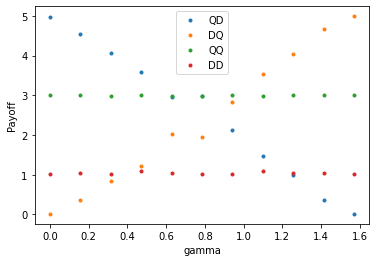

In [41]:
temp1= [x/512*3 for x in QQ_res[0]]; temp2= [x/512*5 for x in QQ_res[2]]
QQ_final = [a + b for a, b in zip(temp1, temp2)]


temp1= [x/512*3 for x in DD_res[0]]; temp2= [x/512*5 for x in DD_res[2]]; temp3= [x/512*1 for x in DD_res[3]]
DD_final = [a + b+c for a, b, c in zip(temp1, temp2,temp3)]

temp1= [x/512*3 for x in QD_res[0]]; temp2= [x/512*5 for x in QD_res[2]]; temp3= [x/512*1 for x in QD_res[3]]
QD_final = [a + b+c for a, b, c in zip(temp1, temp2,temp3)]
QD_final = [(6*3+1015*5+3*1)/1024] + QD_final

temp1= [x/512*3 for x in QD_res[0]]; temp2= [x/512*5 for x in QD_res[1]]; temp3= [x/512*1 for x in QD_res[3]]
DQ_final = [a + b+c for a, b, c in zip(temp1, temp2,temp3)]
DQ_final = [(6*3+1015*0+3*1)/1024] + DQ_final

plt.figure()
plt.plot(gamma_list,QD_final,'.',label='QD')
plt.plot(gamma_list,DQ_final,'.',label='DQ')
plt.plot(gamma_list,QQ_final,'.',label='QQ')
plt.plot(gamma_list,DD_final,'.',label='DD')
plt.xlabel('gamma')
plt.ylabel('Payoff')
plt.legend();

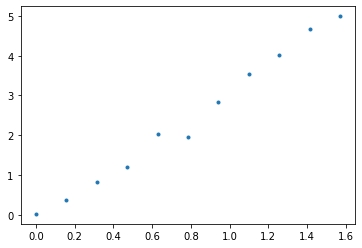

In [38]:
temp1= [x/512*3 for x in QD_res[0]]; temp2= [x/512*5 for x in QD_res[1]]; temp3= [x/512*1 for x in QD_res[3]]
DQ_final = [a + b+c for a, b, c in zip(temp1, temp2,temp3)]
DQ_final = [(6*3+1015*0+3*1)/1024] + DQ_final
plt.figure()
plt.plot(gamma_list,DQ_final,'.')

## Finally we summarize and plot the results above

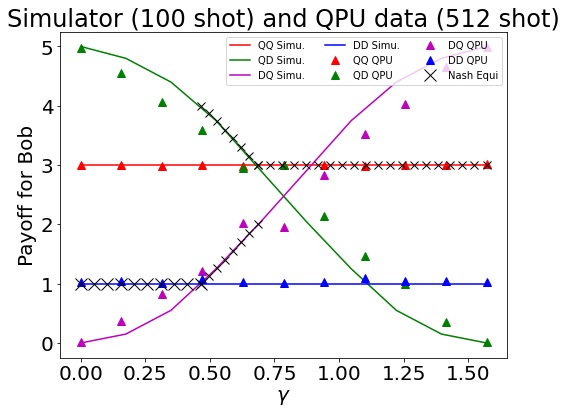

In [53]:
QD_simu = np.array([5.0, 4.8, 4.4, 3.75, 2.9, 2.05, 1.25, 0.55, 0.15, 0.0])
QQ_simu = np.array([3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])
DD_simu = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
DQ_simu = np.array([0.0,0.15,0.55,1.25,2.05,2.9,3.75,4.4,4.8,5.0])
gamma_table_simu = np.pi/2*np.linspace(0,1,10)


QQ_exp = np.array([2.99804688, 2.99609375, 2.9921875 , 2.99804688, 2.98828125,
       2.99414062, 3.        , 2.98632812, 3.        , 3.        ,
       3.015625  ]);      
QD_exp = np.array([4.9765625 , 4.546875  , 4.06640625, 3.5859375 , 2.953125  ,
       2.99414062, 2.1328125 , 1.46679688, 0.9921875 , 0.35351562,
       0.01171875]);          
DD_exp = np.array([1.02539062, 1.04101562, 1.0078125 , 1.0859375 , 1.03320312,
       1.015625  , 1.02929688, 1.08984375, 1.04101562, 1.04296875,
       1.02148438]);
DQ_exp = np.array([0.02050781, 0.3671875 , 0.83398438, 1.21289062, 2.02539062,
       1.95898438, 2.82617188, 3.52734375, 4.02929688, 4.66015625,
       4.9921875 ])
gamma_table = np.pi/2*np.linspace(0,1,11)



plt.figure(figsize=(8,6))
plt.plot(gamma_table_simu, QQ_simu,'r-',label="QQ Simu.")
plt.plot(gamma_table_simu, QD_simu,'g-',label="QD Simu.")
plt.plot(gamma_table_simu, DQ_simu,'m-',label="DQ Simu.")
plt.plot(gamma_table_simu, DD_simu,'b-',label="DD Simu.")


plt.plot(gamma_table, QQ_exp,'r^',label="QQ QPU",markersize=8)
plt.plot(gamma_table, QD_exp,'g^',label="QD QPU",markersize=8)
plt.plot(gamma_table, DQ_exp,'m^',label="DQ QPU",markersize=8)
plt.plot(gamma_table, DD_exp,'b^',label="DD QPU",markersize=8)

gamma_nash = np.linspace(0,np.arcsin(np.sqrt(1/5)),10)
payoff_nash =np.array([1 for i in range(10)])
gamma_nash_2 = np.linspace(np.arcsin(np.sqrt(1/5)),np.arcsin(np.sqrt(2/5)),8)
payoff_nash_2 = 5*np.multiply(np.cos(gamma_nash_2),np.cos(gamma_nash_2))
gamma_nash_3 = np.linspace(np.arcsin(np.sqrt(1/5)),np.arcsin(np.sqrt(2/5)),8)
payoff_nash_3 = 5*np.multiply(np.sin(gamma_nash_2),np.sin(gamma_nash_2))
gamma_nash_4 = np.linspace(np.arcsin(np.sqrt(2/5)),np.pi/2,20)
payoff_nash_4 =np.array([3 for i in range(20)])
plt.plot(gamma_nash, payoff_nash,'kx',label="Nash Equi",markersize=12)
plt.plot(gamma_nash_2, payoff_nash_2,'kx',markersize=8)
plt.plot(gamma_nash_3, payoff_nash_3,'kx',markersize=8)
plt.plot(gamma_nash_4, payoff_nash_4,'kx',markersize=8)


plt.xlabel(r'$\gamma$')
plt.ylabel('Payoff for Bob')
plt.title('Simulator (100 shot) and QPU data (512 shot)')
plt.rcParams.update({'font.size': 20})
plt.legend(loc=1,fontsize=10,ncol=3)
plt.savefig('Alice_Bob_payoff.pdf')
plt.show()
